# Run Training on Azure ML Compute Instance

In this exercise, we will run a deep learning training job on Azure ML Compute Instance


# Predicting cats versus dogs (binary classification)

## Dataset 

The original dataset is avalaible here: [cats and dogs](https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip)

Run the [downlload bash script](01_download_files.sh) to download the publich cats and dogs dataset and uploaded to a storage account. 

Run [Explore Dataset Notebook](02_explore_dataset.ipynb) to mount datstore to compute instance.

## Training Code

In [1]:
import tensorflow as tf
# Placeholder for student's code (3 lines of code)
# Task: import tensorflow and download the dataset locally

2023-08-19 07:18:49.518219: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 07:18:52.309324: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-19 07:19:00.020466: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/intel64/lib:/opt/intel/compiler

In [3]:
tf.version.VERSION

'2.11.1'

Enable MLflow tracking

In [4]:
import mlflow
mlflow.set_experiment('catsanddogsexp')
mlflow.autolog()

2023/08/19 07:19:21 INFO mlflow.tracking.fluent: Experiment with name 'catsanddogsexp' does not exist. Creating a new experiment.
2023/08/19 07:19:21 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


Data need to be present on the compute instance, or development machine. Refer to [explore data set notebook](02_explore_dataset.ipynb) for details on how to mount a registered `Dataset`. 

In [5]:
zip_dir = '/mnt/tmp/cats_dogs'
import pathlib
parent_dir = pathlib.Path(zip_dir)

import os 
print(os.listdir(zip_dir))

['train', 'validation', 'vectorize.py']


In [6]:
# Create 2 variable called train_dir and test_dir that will contain the path to the 'train' and 'validation' folders
train_dir = parent_dir / 'train'
test_dir = parent_dir / 'validation'

print(train_dir)
print(test_dir)

/mnt/tmp/cats_dogs/train
/mnt/tmp/cats_dogs/validation


### Preparing the Dataset

In [7]:
# Import ImageDataGenerator and create an image generator for the training set
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_img_gen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest')


# create an image generator for the testing set
test_img_gen = ImageDataGenerator(rescale=1./255)

# batch size for the data generators.
batch_size=20

# define our data generator by specifying its input stream
train_data_gen = train_img_gen.flow_from_directory(
    batch_size=batch_size, 
    directory=train_dir, 
    target_size=(100, 100), 
    class_mode='binary')

test_data_gen = test_img_gen.flow_from_directory(
    batch_size=batch_size, 
    directory=test_dir, 
    target_size=(100, 100), 
    class_mode='binary')


print(test_data_gen.class_indices)

total_train = 2000
total_val = 1000

print(test_data_gen.image_shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
(100, 100, 3)


### Defining the Architecture of CNN

In [8]:
# import VGG16
from tensorflow.keras.applications import VGG16


# instantiate a model 
input_shape = (100, 100, 3)
base_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

# freeze layers of the base model
frozen_layers = 15
for layer in base_model.layers[:frozen_layers]:
    layer.trainable = False


print('base model summary')
base_model.summary()

2023-08-19 07:19:41.200319: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


58889256/58889256 [==============================] - 0s 0us/step
base model summary
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                           

In [9]:
# add 2 fully connected layers to this VGG16 model

from tensorflow.keras.layers import Flatten, Dense

tuned_model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(500, activation='relu'),
    Dense(1, activation='sigmoid')
])


# instantiate and Adam opetimizer with learning rate of .00001
optimizer = tf.keras.optimizers.Adam(0.00001)


# compile the model and specify loss function 
tuned_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print('tuned model summary')
tuned_model.summary()

tuned model summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 500)               2304500   
                                                                 
 dense_1 (Dense)             (None, 1)                 501       
                                                                 
Total params: 17,019,689
Trainable params: 9,384,425
Non-trainable params: 7,635,264
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functiona

### Training and Evaluation of the Model

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# early stopping if model doesnot improve in 5 epochs 
early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# decrease the learning rate by a factor of 0.2 if the model doesn't improve after 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)

# Model checkpoint location 
checkpoint_filepath = os.path.expanduser('~/cloudfiles/data/model_checkpoint/vgg_checkpoint')
print(checkpoint_filepath)

# save bes model weights during learning process
model_checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

/home/azureuser/cloudfiles/data/model_checkpoint/vgg_checkpoint


In [11]:
# Train for 50 epochs (unless stopped early by callback functions)
history = tuned_model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=50,
    validation_data=test_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[early_stop_cb, reduce_lr, model_checkpoint_cb]
)

/tmp/ipykernel_93136/2923543167.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = tuned_model.fit_generator(


2023/08/19 07:19:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0adb5f87-f50e-42cd-bf3e-e273fdf7bc6b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/08/19 07:20:04 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2023/08/19 07:20:04 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/50
100/100 [==============================] - 630s 6s/step - loss: 0.5683 - accuracy: 0.7035 - val_loss: 0.4152 - val_accuracy: 0.8040 - lr: 1.0000e-05
Epoch 2/50
100/100 [==============================] - 136s 1s/step - loss: 0.4091 - accuracy: 0.8180 - val_loss: 0.3107 - val_accuracy: 0.8570 - lr: 1.0000e-05
Epoch 3/50
100/100 [==============================] - 138s 1s/step - loss: 0.3509 - accuracy: 0.8395 - val_loss: 0.2925 - val_accuracy: 0.8720 - lr: 1.0000e-05
Epoch 4/50
100/100 [==============================] - 137s 1s/step - loss: 0.3191 - accuracy: 0.8585 - val_loss: 0.2681 - val_accuracy: 0.8830 - lr: 1.0000e-05
Epoch 5/50
100/100 [==============================] - 129s 1s/step - loss: 0.3008 - accuracy: 0.8695 - val_loss: 0.2816 - val_accuracy: 0.8850 - lr: 1.0000e-05
Epoch 6/50
100/100 [==============================] - 132s 1s/step - loss: 0.2917 - accuracy: 0.8735 - val_loss: 0.2554 - val_accuracy: 0.8800 - lr: 1.0000e-05
Epoch 7/50
100/100 [====================

2023/08/19 08:25:08 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/08/19 08:25:08 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmphf6lmfo8/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmphf6lmfo8/model/data/model/assets
2023/08/19 08:25:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


## Analysing the Results

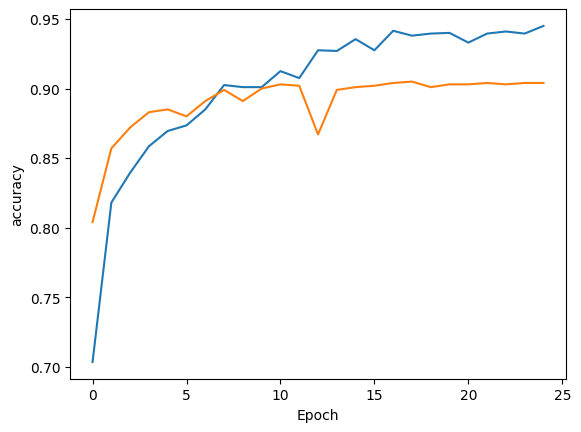

In [12]:
# plot the accuracy for the training and validation set
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()

In [13]:
mlflow.get

TypeError: run() missing 1 required positional argument: 'uri'